# Twitter users gender classification

Schloesing Benjamin, Yao Yuan, Ramet Gaétan

## Introduction

The objective of this project is to find features which can help to determine a Twitter user's gender using machine learning.

## Step 1 : Import data

The dataset we will use is the [Twitter User Gender Classification](https://www.kaggle.com/crowdflower/twitter-user-gender-classification) dataset made available by [Crowdflower](https://www.crowdflower.com/). This datasets contains 20000 entries, each of them being a tweet from different users, with many other associated features which are listed here:

* **_unit_id** : a unique id for each user
* **_golden** : a boolean which states whether the user is included in the golden standard for the model
* **_unit_state** : the state of the obervation, eiter *golden* for gold standards or *finalized* for contributor-judged
* **_trusted_judgments** : the number of judgment on a user's gender. 3 for non-golden, or a unique id for golden
* **_last_judgment_at** : date and time of the last judgment, blank for golden observations
* **gender** : either *male*, *female* or *brand* for non-human profiles
* **gender:confidence** : a float representing the confidence of the gender judgment
* **profile_yn** : either *yes* or *no*, *no* meaning that the user's profile was not available when contributors went to judge it
* **created** : date and time of when the profile was created
* **description** : the user's Tweeter profile description
* **fav_number** : the amount of favorited tweets by the user
* **gender_gold** : the gender if the profile is golden
* **link_color** : the link color of the profile as a hex value
* **name** : the Tweeter user's name
* **profile_yn_gold** : *yes* or *no* whether the profile y/n value is golden
* **profileimage** : a link to the profile image
* **retweet_count** : the number of times the user has retweeted something
* **sidebar_color** : color of the profile sidebar as a hex value
* **text** : text of a random tweet from the user
* **tweet_coord** : if the location was available at the time of the tweet, the coordinates as a string ith the format[latitude, longitude]
* **tweet_count** : number of tweet of the users
* **tweet_created** : the time of the random tweet in **text**
* **tweet_id** : the tweet id of the random tweet
* **tweet_location** : the location of the tweet, based on the coordinates
* **user_timezone** : the timezone of the user

Most of these features are not relevant for our analysis, we will only focus on a few of them

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

#graph
from bokeh.plotting import output_notebook, figure, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource

%matplotlib notebook 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

from matplotlib import pyplot as plt
# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

from collections import Counter

import plotly.plotly as py
import plotly.graph_objs as go




# we need latin-1 encoding because there are some special characters (é,...) that do not fit in default UTF-8
dataFrame = pd.read_csv('gender-classifier-DFE-791531.csv', encoding='latin-1')

#Show a sample of the dataset
dataFrame.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [2]:
print(list(dataFrame))

['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn', 'profile_yn:confidence', 'created', 'description', 'fav_number', 'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage', 'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count', 'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone']


['#0084B400000', '#F5ABB500000', '#9266CC00000', '#DD2E4400000', '#FF000000000', '#ABB8C200000', '#3B94D900000', '#000000', '#999900000', '#B40B4300000', '#0099B900000', '#89C9FA00000', '#3854300000', '#4A913C00000', '#2FC2EF00000', '#FA743E00000', '#94D48700000', '#CC336600000', '#99000000000', '#D02B5500000']


<IPython.core.display.Javascript object>


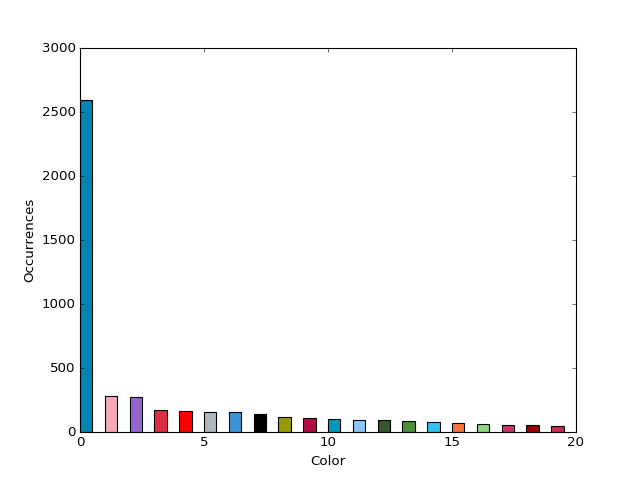

In [8]:
dataFrameLinkCol = dataFrame.loc[:,['gender:confidence', 'gender', 'link_color']]
dataFrameLinkColSorted = dataFrameLinkCol.sort_values(by = 'gender:confidence', ascending = False)
#print(dataFrameColSorted.query('1 in @gender:confidence))
dataFrameLinkColFiltered = dataFrameLinkCol[dataFrameLinkCol['gender:confidence'] > 0.5]
#print(dataFrameColFiltered)

dataFrameLinkColFilteredMale = dataFrameLinkColFiltered[dataFrameLinkColFiltered['gender'] == 'male']
dataFrameLinkColFilteredFemale = dataFrameLinkColFiltered[dataFrameLinkColFiltered['gender'] == 'female']
dataFrameLinkColFilteredBrand = dataFrameLinkColFiltered[dataFrameLinkColFiltered['gender'] == 'brand']

linkColorMale = dataFrameLinkColFilteredMale['link_color']
linkColorFemale = dataFrameLinkColFilteredFemale['link_color']
linkColorBrand = dataFrameLinkColFilteredBrand['link_color']

varLinkMale = list(linkColorMale.values.flatten())
varLinkFemale = list(linkColorFemale.values.flatten())

colFemaleDict = Counter(varLinkFemale).most_common(20)
#print(type(colFemaleDict[1][0]))
#print(colFemaleDict[0])
couleurs = [x[0] for x in colFemaleDict]
#print(couleurs)
couleursNumb = [x[1] for x in colFemaleDict]
couleursHex1 = ['#' + x + '00000' for x in couleurs]
print(couleursHex1)
couleursHex = [x[0: 7] for x in couleursHex1]


fig, ax = plt.subplots()

bar_width = 0.5
rects1 = plt.bar(list(range(len(couleurs))), couleursNumb, bar_width, label = 'Female', color = couleursHex )
plt.xlabel('Color')
plt.ylabel('Occurrences')
plt.show()

#trace1 = go.Bar(x = couleurs, y = couleursNumb, name = 'Female Colors')
#data = [trace1]
#layout = go.Layout(barmode = 'group')
#fig = go.Figure(data = data, layout = layout)
#py.iplot(fig,filename = 'grouped-bard')




<IPython.core.display.Javascript object>


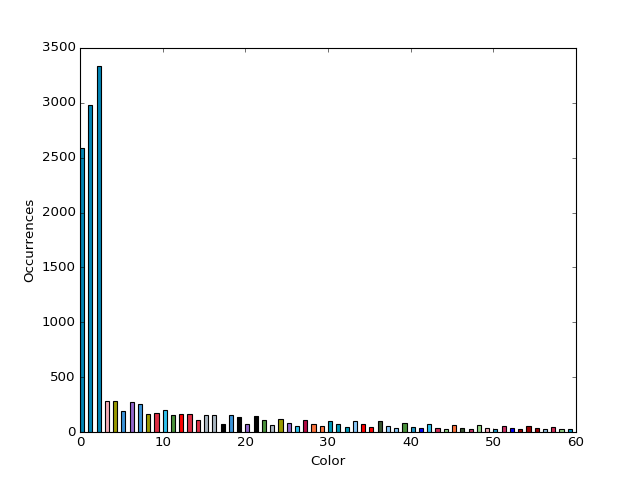

<IPython.core.display.Javascript object>


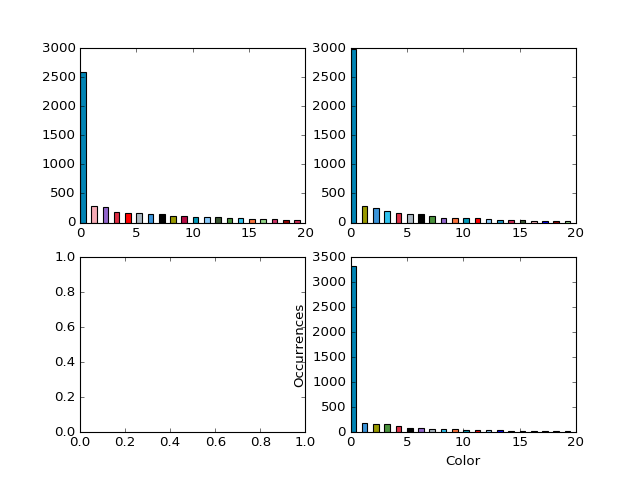

<IPython.core.display.Javascript object>


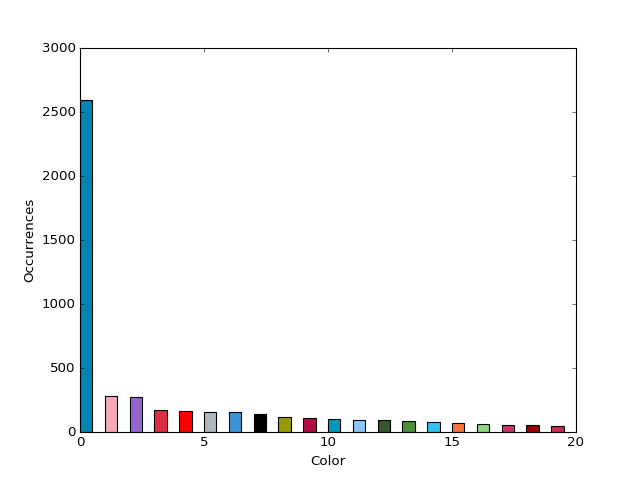

<IPython.core.display.Javascript object>


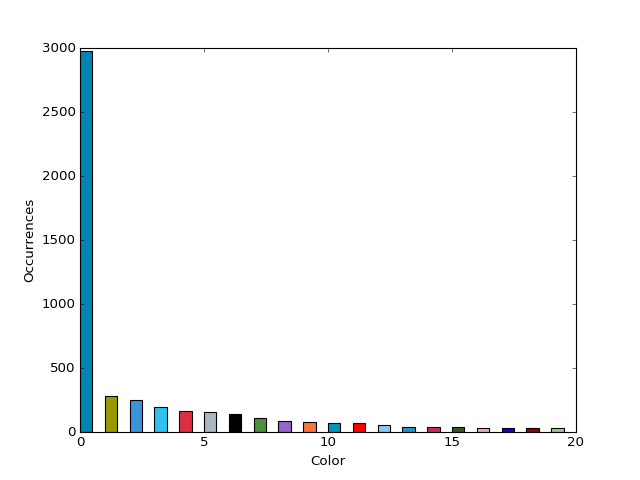

<IPython.core.display.Javascript object>


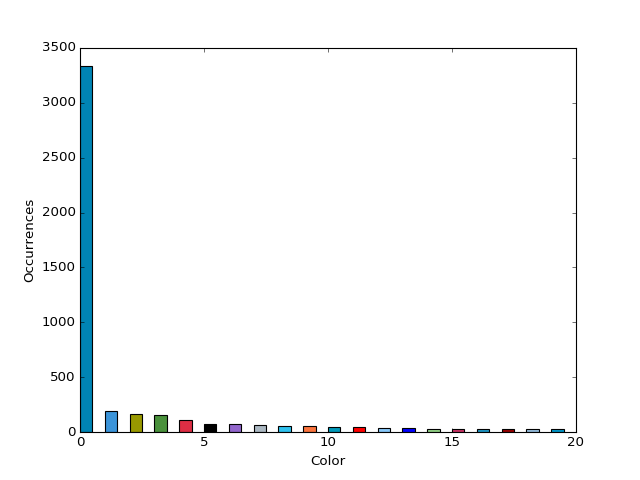

In [23]:
dataFrameLinkCol = dataFrame.loc[:,['gender:confidence', 'gender', 'link_color']]
dataFrameLinkColSorted = dataFrameLinkCol.sort_values(by = 'gender:confidence', ascending = False)
#print(dataFrameColSorted.query('1 in @gender:confidence))
dataFrameLinkColFiltered = dataFrameLinkCol[dataFrameLinkCol['gender:confidence'] > 0.5]
#print(dataFrameColFiltered)

dataFrameLinkColFilteredMale = dataFrameLinkColFiltered[dataFrameLinkColFiltered['gender'] == 'male']
dataFrameLinkColFilteredFemale = dataFrameLinkColFiltered[dataFrameLinkColFiltered['gender'] == 'female']
dataFrameLinkColFilteredBrand = dataFrameLinkColFiltered[dataFrameLinkColFiltered['gender'] == 'brand']

linkColorMale = dataFrameLinkColFilteredMale['link_color']
linkColorFemale = dataFrameLinkColFilteredFemale['link_color']
linkColorBrand = dataFrameLinkColFilteredBrand['link_color']

varLinkMale = list(linkColorMale.values.flatten())
varLinkFemale = list(linkColorFemale.values.flatten())
varLinkBrand = list(linkColorBrand.values.flatten())

colLinkFemale = Counter(varLinkFemale).most_common(20)
colLinkMale = Counter(varLinkMale).most_common(20)
colLinkBrand = Counter(varLinkBrand).most_common(20)

colorsFemale = [x[0] for x in colLinkFemale]
colorsMale = [x[0] for x in colLinkMale]
colorsBrand = [x[0] for x in colLinkBrand]

colorsNumbFemale = [x[1] for x in colLinkFemale]
colorsNumbMale = [x[1] for x in colLinkMale]
colorsNumbBrand = [x[1] for x in colLinkBrand]

colorsHexFemale1 = ['#' + x + '000000' for x in colorsFemale]
colorsHexFemale = [x[0:7] for x in colorsHexFemale1]
colorsHexMale1 = ['#' + x + '000000' for x in colorsMale]
colorsHexMale = [x[0:7] for x in colorsHexMale1]
colorsHexBrand1 = ['#' + x + '000000' for x in colorsBrand]
colorsHexBrand = [x[0:7] for x in colorsHexBrand1]



rangeColFemale1 = list(range(len(colorsFemale)))
rangeColFemale = [3*x for x in rangeColFemale1]

rangeColMale1 = list(range(len(colorsMale)))
rangeColMale = [3*x + 1 for x in rangeColMale1]

rangeColBrand1 = list(range(len(colorsBrand)))
rangeColBrand = [3*x + 2 for x in rangeColBrand1]



fig, ax = plt.subplots()

bar_width = 0.5
#rects1 = plt.bar(list(range(len(couleurs))), couleursNumb, bar_width, label = 'Female', color = couleursHex )
rects1 = plt.bar(rangeColFemale, colorsNumbFemale, bar_width, label = 'Female', color = colorsHexFemale)
rects2 = plt.bar(rangeColMale, colorsNumbMale, bar_width, label = 'Male', color = colorsHexMale)
rects3 = plt.bar(rangeColBrand, colorsNumbBrand, bar_width, label = 'Brand', color = colorsHexBrand)
plt.xlabel('Color')
plt.ylabel('Occurrences')
plt.show()

fig, axarr = plt.subplots(2,2)
bar_width = 0.5
#rects1 = plt.bar(list(range(len(couleurs))), couleursNumb, bar_width, label = 'Female', color = couleursHex )
axarr[0,0].bar(rangeColFemale1, colorsNumbFemale, bar_width, label = 'Female', color = colorsHexFemale)
axarr[0,1].bar(rangeColMale1, colorsNumbMale, bar_width, label = 'Male', color = colorsHexMale)
axarr[1,1].bar(rangeColBrand1, colorsNumbBrand, bar_width, label = 'Brand', color = colorsHexBrand)
plt.xlabel('Color')
plt.ylabel('Occurrences')
plt.show()

fig1, ax1 = plt.subplots()

bar_width = 0.5
rects1 = plt.bar(rangeColFemale1, colorsNumbFemale, bar_width, label = 'Female', color = colorsHexFemale)
plt.xlabel('Color')
plt.ylabel('Occurrences')
plt.show()

fig2, ax2 = plt.subplots()

bar_width = 0.5
rects1 = plt.bar(rangeColMale1, colorsNumbMale, bar_width, label = 'Male', color = colorsHexMale)
plt.xlabel('Color')
plt.ylabel('Occurrences')
plt.show()

fig3, ax3 = plt.subplots()

bar_width = 0.5
rects1 = plt.bar(rangeColBrand1, colorsNumbBrand, bar_width, label = 'Brand', color = colorsHexBrand)
plt.xlabel('Color')
plt.ylabel('Occurrences')
plt.show()



In [4]:


#print(couleursNumb)
#print(Counter(varLinkFemale).most_common(20))
#print(Counter(varLinkMale).most_common(20))
couleursHex1 = ['#' + x + '00000' for x in couleurs]
print(couleursHex1)
couleursHex = [x[0: 7] for x in couleursHex1]
print(len(couleursHex))
couleursRange = list(range(len(couleurs)))
print(couleursRange)
print(couleurs)
couleursInt = [int(x, 16) for x in couleurs]
print(couleursInt)
#n, bins, patches = plt.hist(couleursRange, couleursNumb, 25, normed = 1, color = 'green')
n, bins, patches = plt.hist(couleursInt, 25, normed = 1, color = 'green')

for c, p in zip(couleursRange, patches):
    plt.setp(p, 'facecolor', couleursHex[c])

['#0084B400000', '#F5ABB500000', '#9266CC00000', '#DD2E4400000', '#FF000000000', '#ABB8C200000', '#3B94D900000', '#000000', '#999900000', '#B40B4300000', '#0099B900000', '#89C9FA00000', '#3854300000', '#4A913C00000', '#2FC2EF00000', '#FA743E00000', '#94D48700000', '#CC336600000', '#99000000000', '#D02B5500000']
20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
['0084B4', 'F5ABB5', '9266CC', 'DD2E44', 'FF0000', 'ABB8C2', '3B94D9', '0', '9999', 'B40B43', '0099B9', '89C9FA', '38543', '4A913C', '2FC2EF', 'FA743E', '94D487', 'CC3366', '990000', 'D02B55']
[33972, 16100277, 9594572, 14495300, 16711680, 11253954, 3904729, 0, 39321, 11799363, 39353, 9030138, 230723, 4886844, 3130095, 16413758, 9753735, 13382502, 10027008, 13642581]


In [5]:
#dataFrame = dataFrame.sort_values(by = '_golden', ascending = False)
#dataFrame = dataFrame.sort_values(by = 'gender:confidence', ascending = False)
#display(dataFrame['profileimage'][1:10])

#Get profile pictures, to have it big just remove '_normal'
#pd.options.display.max_colwidth = 100
#print(dataFrame.loc[:10, 'profileimage'])

dataFrameCol = dataFrame.loc[:,['gender:confidence', 'gender', 'sidebar_color']]
dataFrameColSorted = dataFrameCol.sort_values(by = 'gender:confidence', ascending = False)
#print(dataFrameColSorted.query('1 in @gender:confidence))
dataFrameColFiltered = dataFrameCol[dataFrameCol['gender:confidence'] > 0.5]
#print(dataFrameColFiltered)

dataFrameColFilteredMale = dataFrameColFiltered[dataFrameColFiltered['gender'] == 'male']
dataFrameColFilteredFemale = dataFrameColFiltered[dataFrameColFiltered['gender'] == 'female']
dataFrameColFilteredBrand = dataFrameColFiltered[dataFrameColFiltered['gender'] == 'brand']

colorMale = dataFrameColFilteredMale['sidebar_color']
colorFemale = dataFrameColFilteredFemale['sidebar_color']
colorBrand = dataFrameColFilteredBrand['sidebar_color']

varMale = list(colorMale.values.flatten())
varFemale = list(colorFemale.values.flatten())

print(Counter(varFemale))
print(Counter(varMale))

Counter({'C0DEED': 2425, 'FFFFFF': 1470, '0': 1448, 'EEEEEE': 206, '65B0DA': 118, '5ED4DC': 79, 'CC3366': 76, '181A1E': 75, '829D5E': 47, 'DBE9ED': 43, 'DFDFDF': 40, 'D3D2CF': 37, 'A8C7F7': 36, 'BDDCAD': 31, 'FFF8AD': 31, 'F2E195': 28, '86A4A6': 27, 'D9B17E': 21, 'C6E2EE': 18, 'F0A830': 10, '87BC44': 7, 'ADF1FC': 5, '696969': 3, 'BFBFBF': 3, '4A66C1': 3, '80434B': 2, 'FCF3B8': 2, 'D6DBAD': 2, 'FF0000': 2, '89B5A2': 2, '333333': 2, 'AEF5FA': 2, 'FFB93C': 2, '0F0E0F': 1, 'FFF1E8': 1, '022C74': 1, 'B1C4E6': 1, '4.43E+03': 1, '222222': 1, '373737': 1, '0D0014': 1, '1351CF': 1, 'FCD3BB': 1, 'E60E18': 1, 'F6F3EA': 1, '9A17EB': 1, '909090': 1, '8BA7C4': 1, 'E6056A': 1, 'EEA525': 1, 'E8E8E8': 1, '3BE0F4': 1, 'DB0F6B': 1, 'FEF9E6': 1, 'C9B180': 1, 'E6D56A': 1, 'EBAAAA': 1, '64533E': 1, 'B09797': 1, 'FFA6A6': 1, '515': 1, '463A4A': 1, '80000': 1, '4456BC': 1, 'A7737D': 1, '9000FF': 1, '4B0202': 1, 'E3DB3F': 1, 'D6BD89': 1, 'DE2C56': 1, '202A2B': 1, 'BF0606': 1, '737373': 1, 'D5C788': 1, '665C5C'

In [6]:



#print((colorMale.iloc[3]))
#var1 = colorMale.iloc[3]
#xvar1 = int(var1[0:3], 16)
#yvar1 = int(var1[3:6], 16)
#print(xvar1, yvar1)

#Remove 1.1E17 value ?? 
varMale = list(colorMale.values.flatten())
varMale.remove('1.10E+17')
varMale.remove('6.90E+29')
#print(varMale)
rVarMale = [int(x[0:2], 16) for x in varMale]
#print(xVarMale)
#intXVarMale = [int(x, 16) for x in xVarMale]
#xvarMale = int(varMale[:][0:3], 16)
#print(intXVarMale)
#gVarMale = [int('0' + x[4:6], 16) for x in varMale]
#bVarMale = [int('0' + x[2:4], 16) for x in varMale]

varFemale = list(colorFemale.values.flatten())
varFemale.remove('4.43E+03')
varFemale.remove('2.62E+55')
varFemale.remove('5.94E+61')
varFemale.remove('5.22E+22')
#print(varFemale)

rVarFemale = [int(x[0:2], 16) for x in varFemale]
gVarFemale = [int('0' + x[2:4], 16) for x in varFemale]
bVarFemale = [int('0' + x[4:6], 16) for x in varFemale]
#print(yVarFemale)

varBrand = list(colorBrand.values.flatten())
#print(varBrand)
rVarBrand = [int(x[0:2], 16) for x in varBrand]
gVarBrand = [int('0' + x[2:4], 16) for x in varBrand]
bVarBrand = [int('0' + x[4:6], 16) for x in varBrand]
#print(xVarBrand)


print(Counter(varFemale))
print(Counter(varMale))

n = 100
#plt.figure(figsize=(15, 5))
#plt.plot(xVarBrand, yVarBrand, '.', alpha=.7, markersize=10, label='Brand')
#plt.plot(xVarMale, yVarMale, '.',alpha=.7, markersize=10, label='Male')
#plt.plot(xVarFemale, yVarFemale, '.',alpha=.7, markersize=10, label='Female')
#plt.legend()
#plt.show()

#Axes3D.scatter(xs, ys, zs=0, zdir='z', s=20, c=None, depthshade=True, *args, **kwargs)
# 3D Visualization
fig = pylab.figure(15)
ax = Axes3D(fig)
ax.scatter(rVarBrand, gVarBrand, bVarBrand, color = 'red')
ax.scatter(rVarMale, gVarMale, bVarMale, color = 'blue')
ax.scatter(rVarFemale, gVarFemale, bVarFemale, color = 'green')
pylab.title('Color Visualization')
pyplot.show()

#Trier couleurs selon : 3 premiers chiffres, 3 derniers (FFF, FFF) -> x,y graphs 

#print(dataFrame['profileimage'][1:10])
#print(pd.Series.value_counts(dataFrame['_golden']))
#print('coucou')
#print(pd.Series.value_counts(dataFrame['gender:confidence']))




ValueError: invalid literal for int() with base 16: '3.'

In [19]:
#Get profile pictures, to have it big just remove '_normal'
pd.options.display.max_colwidth = 100
print(dataFrame.loc[1, 'profileimage'])

from PIL import Image 
from io import BytesIO
import requests

url = dataFrame.loc[1, 'profileimage']
response = requests.get(url)
img = Image.open(BytesIO(response.content))
print(img.format)  # 'JPEG'

https://pbs.twimg.com/profile_images/539604221532700673/WW16tBbU_normal.jpeg
JPEG
